In [10]:

import pandas as pd
import seaborn as sns
from pandas.plotting import scatter_matrix



In [51]:

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
from matplotlib import cm
import seaborn as sns
from matplotlib import rc

###############################################################################
# Displaying labeled data
###############################################################################

symlist = ['o', 'p', '*', 's', '+', 'x', 'D', 'v', '-', '^']

rc('font', **{'family': 'sans-serif', 'sans-serif': ['Computer Modern Roman']})
params = {'axes.labelsize': 12,
          'font.size': 16,
          'legend.fontsize': 16,
          'text.usetex': False,
          'figure.figsize': (8, 6)}
plt.rcParams.update(params)

sns.set_context("poster")
sns.set_palette("colorblind")
sns.set_style("white")
sns.axes_style()

###############################################################################
#    Data Generation    (you can skip the understanding)
###############################################################################


def rand_gauss(n=100, mu=[1, 1], sigmas=[0.1, 0.1]):
    """Sample  points from a Gaussian variable.

    Parameters
    ----------
    n : number of samples

    mu : centered

    sigma : standard deviation
    """
    d = len(mu)
    res = np.random.randn(n, d)
    return np.array(mu + res * sigmas)


def rand_bi_gauss(n1=100, n2=100, mu1=[1, 1], mu2=[-1, -1], sigmas1=[0.1, 0.1],
                  sigmas2=[0.1, 0.1]):
    """Sample points from two Gaussian distributions.

    Parameters
    ----------
    n1 : number of sample from first distribution

    n2 : number of sample from second distribution

    mu1 : center for first distribution

    mu2 : center for second distribution

    sigma1: std deviation for first distribution

    sigma2: std deviation for second distribution
    """
    ex1 = rand_gauss(n1, mu1, sigmas1)
    ex2 = rand_gauss(n2, mu2, sigmas2)
    y = np.hstack([np.ones(n1), -1 * np.ones(n2)])
    X = np.vstack([ex1, ex2])
    ind = np.random.permutation(n1 + n2)
    return X[ind, :], y[ind]


def rand_clown(n1=100, n2=100, sigma1=1, sigma2=2):
    """Create samples and labels form a **clown** dataset.

    Parameters
    ----------
    n1 : number of sample from first blob

    n2 : number of sample from second blob

    sigma1 :  noise std deviation for the first blob

    sigma2 :  noise std deviation for the second blob
    """
    x0 = np.random.randn(n1, 1)
    x1 = x0 * x0 + sigma1 * np.random.randn(n1, 1)
    x2 = np.hstack([sigma2 * np.random.randn(n2, 1),
                    sigma2 * np.random.randn(n2, 1) + 2.])
    X = np.vstack([np.hstack([x0, x1]), x2])
    y = np.hstack([np.ones(n1), -1 * np.ones(n2)])
    ind = np.random.permutation(n1 + n2)
    return X[ind, :], y[ind]


def rand_checkers(n1=100, n2=100, sigma=0.1):
    """Create samples and labels from a noisy checker.

    Parameters
    ----------
    n1 : number of samples for the first class

    n2 : number of samples for the second class
    """
    nbp = int(np.floor(n1 / 8))
    nbn = int(np.floor(n2 / 8))
    xapp = np.reshape(np.random.rand((nbp + nbn) * 16), [(nbp + nbn) * 8, 2])
    yapp = np.ones((nbp + nbn) * 8)
    idx = 0
    for i in range(-2, 2):
        for j in range(-2, 2):
            if (((i + j) % 2) == 0):
                nb = nbp
            else:
                nb = nbn
                yapp[idx:(idx + nb)] = [-1] * nb

            xapp[idx:(idx + nb), 0] = np.random.rand(nb)
            xapp[idx:(idx + nb), 0] += i + sigma * np.random.randn(nb)
            xapp[idx:(idx + nb), 1] = np.random.rand(nb)
            xapp[idx:(idx + nb), 1] += j + sigma * np.random.randn(nb)
            idx += nb

    ind = np.random.permutation((nbp + nbn) * 8)
    res = np.hstack([xapp, yapp[:, np.newaxis]])
    return np.array(res[ind, :2]), np.array(res[ind, 2])


###############################################################################
#            Displaying labeled data
###############################################################################
symlist = ['o', 's', '+', 'x', 'D', '*', 'p', 'v', '-', '^']
collist = ['blue', 'red', 'purple', 'orange', 'salmon', 'black', 'grey',
           'fuchsia']


def plot_2d(X, y, w=None, step=50, alpha_choice=1):
    """2D dataset data ploting according to labels.

    Parameters
    ----------

    X : data features

    y : label vector

    w :(optional) the separating hyperplan w

    alpha_choice : control alpha display parameter
    """
    min_tot0 = np.min(X[:, 0])
    min_tot1 = np.min(X[:, 1])

    max_tot0 = np.max(X[:, 0])
    max_tot1 = np.max(X[:, 1])
    delta0 = (max_tot0 - min_tot0)
    delta1 = (max_tot1 - min_tot1)
    labels = np.unique(y)
    k = np.unique(y).shape[0]
    color_blind_list = sns.color_palette("colorblind", k)
    color_blind_list[1] = [1,0,0]
    sns.set_palette(color_blind_list)
    for i, label in enumerate(y):
        label_num = np.where(labels == label)[0][0]
        plt.scatter(X[i, 0], X[i, 1], c=color_blind_list[label_num],
                    s=80, marker=symlist[label_num])
    plt.xlim([min_tot0 - delta0 / 10., max_tot0 + delta0 / 10.])
    plt.ylim([min_tot1 - delta1 / 10., max_tot1 + delta1 / 10.])
    if w is not None:
        plt.plot([min_tot0, max_tot0],
                 [min_tot0 * -w[1] / w[2] - w[0] / w[2],
                  max_tot0 * -w[1] / w[2] - w[0] / w[2]],
                 "k", alpha=alpha_choice)


###############################################################################
#               Loss functions and their gradient
###############################################################################

def predict(x, w):
    """Prediction from a normal vector."""
    return np.dot(x, w[1:]) + w[0]


def predict_class(x, w):
    """Predict a class from at point x thanks to a normal vector."""
    return np.sign(predict(x, w))


def zero_one_loss(x, y, w):
    """0-1 loss function."""
    return abs(y - np.sign(predict(x, w))) / 2.


def hinge_loss(x, y, w):
    """Hinge loss function."""
    return np.maximum(0., 1. - y * predict(x, w))


def mse_loss(x, y, w):
    """Mean square error loss."""
    return (y - predict(x, w)) ** 2


def norm2(x, y, w):
    """Squared norm of a vector."""
    return np.dot(w, w)


def gr_hinge_loss(x, y, w):
    """Sub-gradient of the loss function hingeloss."""
    return np.dot(-y * (hinge_loss(x, y, w) > 0.),
                  np.hstack((np.ones((x.shape[0], 1)), x)))


def gr_mse_loss(x, y, w):
    """Gradient of the least squares lost function."""
    return -2. * np.dot(y - predict(x, w),
                        np.hstack((np.ones((x.shape[0], 1)), x)))


def gr_norm2(x, y, w):
    """Gradient of the squared norm."""
    return 2. * w


def pen_loss_aux(x, y, w, l):
    """Loss function penalized by hinge loss."""
    return hinge_loss(x, y, w) + l * norm2(x, y, w)


def gr_pen_loss_aux(x, y, w, l):
    """Gradient of hinge loss penalized loss function."""
    return gr_hinge_loss(x, y, w) + l * gr_norm2(x, y, w, )


def pen_loss(l):
    """Penalized loss function."""
    return lambda x, y, w: pen_loss_aux(x, y, w, l)


def gr_pen_loss(l):
    """Gradient penalized loss function."""
    return lambda x, y, w: gr_pen_loss_aux(x, y, w, l)


###############################################################################
#            Displaying tools for the Frontiere
###############################################################################


def frontiere(f, X, step=50, cmap_choice=cm.coolwarm):
    """Frontiere plotting for a decision function f."""
    min_tot0 = np.min(X[:, 0])
    max_tot0 = np.max(X[:, 0])
    min_tot1 = np.min(X[:, 1])
    max_tot1 = np.max(X[:, 1])
    delta0 = (max_tot0 - min_tot0)
    delta1 = (max_tot1 - min_tot1)
    xx, yy = np.meshgrid(np.arange(min_tot0, max_tot0, delta0 / step),
                         np.arange(min_tot1, max_tot1, delta1 / step))
    z = np.array([f(vec) for vec in np.c_[xx.ravel(), yy.ravel()]])
    z = z.reshape(xx.shape)
    plt.imshow(z, origin='lower', interpolation="nearest", cmap=cmap_choice,
               extent=[min_tot0, max_tot0, min_tot1, max_tot1])
    plt.colorbar()


def frontiere_new(clf, X, y, w=None, step=50, alpha_choice=1, colorbar=True,
                  samples=True, n_labels=3, n_neighbors=3):
    """Trace la frontiere pour la fonction de decision de clf."""
    min_tot0 = np.min(X[:, 0])
    min_tot1 = np.min(X[:, 1])

    max_tot0 = np.max(X[:, 0])
    max_tot1 = np.max(X[:, 1])
    delta0 = (max_tot0 - min_tot0)
    delta1 = (max_tot1 - min_tot1)
    xx, yy = np.meshgrid(np.arange(min_tot0, max_tot0, delta0 / step),
                         np.arange(min_tot1, max_tot1, delta1 / step))
    XX = np.c_[xx.ravel(), yy.ravel()]
    print(XX.shape)
    z = clf.predict(XX)
    z = z.reshape(xx.shape)
    labels = np.unique(z)
    color_blind_list = sns.color_palette("colorblind", labels.shape[0])
    my_cmap = ListedColormap(color_blind_list)
    plt.imshow(z, origin='lower', interpolation="mitchell", alpha=0.80,
               cmap=my_cmap, extent=[min_tot0, max_tot0, min_tot1, max_tot1])
    if colorbar is True:
        ax = plt.gca()
        cbar = plt.colorbar(ticks=labels)
        cbar.ax.set_yticklabels(labels)

    # color_blind_list = sns.color_palette("colorblind", labels.shape[0])
    # sns.set_palette(color_blind_list)
    ax = plt.gca()
    if samples is True:
        for i, label in enumerate(y):
            label_num = np.where(labels == label)[0][0]
            plt.scatter(X[i, 0], X[i, 1], c=color_blind_list[label_num],
                        s=80, marker=symlist[label_num])
    plt.xlim([min_tot0, max_tot0])
    plt.ylim([min_tot1, max_tot1])
    ax.get_yaxis().set_ticks([])
    ax.get_xaxis().set_ticks([])
    if w is not None:
        plt.plot([min_tot0, max_tot0],
                 [min_tot0 * -w[1] / w[2] - w[0] / w[2],
                  max_tot0 * -w[1] / w[2] - w[0] / w[2]],
                 "k", alpha=alpha_choice)
    plt.title("L=" + str(n_labels) + ",k=" +
              str(n_neighbors))


def frontiere_3d(f, data, step=20):
    """Plot the 3d frontiere for the decision function f."""
    ax = plt.gca(projection='3d')
    xmin, xmax = data[:, 0].min() - 1., data[:, 0].max() + 1.
    ymin, ymax = data[:, 1].min() - 1., data[:, 1].max() + 1.
    xx, yy = np.meshgrid(np.arange(xmin, xmax, (xmax - xmin) * 1. / step),
                         np.arange(ymin, ymax, (ymax - ymin) * 1. / step))
    z = np.array([f(vec) for vec in np.c_[xx.ravel(), yy.ravel()]])
    z = z.reshape(xx.shape)
    ax.plot_surface(xx, yy, z, rstride=1, cstride=1,
                    linewidth=0., antialiased=False,
                    cmap=plt.cm.coolwarm)


def plot_cout(X, y, loss_fun, w=None):
    """Plot the cost function encoded by loss_fun,

    Parameters
    ----------
    X : data features
    y :  labels
    loss_fun : loss function
    w : (optionnal) can be used to give a historic path of the weights """
    def _inter(wn):
        ww = np.zeros(3)
        ww[1:] = wn
        return loss_fun(X, y, ww).mean()
    datarange = np.array([[np.min(X[:, 0]), np.min(X[:, 1])],
                          [np.max(X[:, 0]), np.max(X[:, 1])]])
    frontiere(_inter, np.array(datarange))
    if w is not None:
        plt.plot(w[:, 1], w[:, 2], 'k')
    plt.xlim([np.min(X[:, 0]), np.max(X[:, 0])])
    plt.ylim([np.min(X[:, 1]), np.max(X[:, 1])])


def plot_cout3d(x, y, loss_fun, w):
    """ trace le cout de la fonction cout loss_fun passee en parametre, en x,y,
        en faisant varier les coordonnees du poids w.
        W peut etre utilise pour passer un historique de poids"""
    def _inter(wn):
        ww = np.zeros(3)
        ww[1:] = wn
        return loss_fun(x, y, ww).mean()

    datarange = np.array([[w[:, 1].min(), w[:, 2].min()],
                         [w[:, 1].max(), w[:, 2].max()]])
    frontiere_3d(_inter, np.array(datarange))
    plt.plot(w[:, 1], w[:, 2], np.array([_inter(w[i, 1:]) for i in
             range(w.shape[0])]), 'k-', linewidth=3)

###############################################################################
#                Algorithms and functions
###############################################################################


def gradient(x, y, eps, niter, w_ini, loss_fun, gr_loss_fun, stochastic=True):
    """ algorithme de descente du gradient:
        - x : donnees
        - y : label
        - eps : facteur multiplicatif de descente
        - niter : nombre d'iterations
        - w_ini
        - loss_fun : fonction de cout
        - gr_loss_fun : gradient de la fonction de cout
        - stoch : True : gradient stochastique
        """
    w = np.zeros((niter, w_ini.size))
    w[0] = w_ini
    loss = np.zeros(niter)
    loss[0] = loss_fun(x, y, w[0]).mean()
    for i in range(1, niter):
        if stochastic:  # this is for Stochastic Gradient Descent
            idx = [np.random.randint(x.shape[0])]
        else:           # this is for pure Gradient Descent
            idx = np.arange(x.shape[0])
        w[i, :] = w[i - 1, :] - eps * gr_loss_fun(x[idx, :],
                                                  y[idx], w[i - 1, :])
        loss[i] = loss_fun(x, y, w[i, :]).mean()
    return w, loss


def plot_gradient(X, y, wh, cost_hist, loss_fun):
    """ display 4 figures on how  (stochastic) gradient descent behaves
    wh : solution history
    cost_hist : cost history
    loss_fun : loss function
    """
    best = np.argmin(cost_hist)
    plt.subplot(221)
    plt.title('Data and hyperplane estimated')
    plot_2d(X, y, wh[best, :])
    plt.subplot(222)
    plt.title('Projection of level line and algorithm path')
    plot_cout(X, y, loss_fun, wh)
    plt.subplot(223)
    plt.title('Objective function vs iterations')
    plt.plot(range(cost_hist.shape[0]), cost_hist)
    plt.subplot(224, projection='3d')
    plt.title('Level line and algorithm path')
    plot_cout3d(X, y, loss_fun, wh)


###############################################################################
#                Polynomial transformations
###############################################################################


def poly2(x):
    """ creates features for second order interactions """
    if x.ndim == 1:
        x = x[None, :]
    nb, d = x.shape
    res = x
    for i in range(0, d):
        for j in range(i, d):
            res = np.hstack((res, x[:, i:i + 1] * x[:, j:j + 1]))
    return res


def poly3(x):
    """ creates features for third order interactions """
    if x.ndim == 1:
            x = x[None, :]
    nb, d = x.shape
    res = poly2(x)
    for i in range(0, d):
        for j in range(i, d):
            for k in range(j, d):
                res = np.hstack(
                    (res, x[:, i:i + 1] * x[:, j:j + 1] * x[:, k:k + 1]))
    return res



In [52]:
gauss= rand_gauss(4,[1, 1],[2, 2])
print(gauss)

[[ 2.79561057  0.95407502]
 [ 3.35645068 -0.48673011]
 [-0.33567223  1.6843902 ]
 [ 3.31184861 -0.70695905]]


In [53]:
#gauss= rand_bi_gauss(4,mu=[1, 1], sigmas=[2, 2])


In [54]:
clown= rand_clown(3, 3,1, 2)

print(clown)

(array([[ 1.12855979,  0.22205415],
       [-0.55413744, -1.27990511],
       [ 0.16962712, -1.07410904],
       [-0.92094709,  0.18093928],
       [ 0.36389062, -0.28379849],
       [-2.70512529,  0.86733396]]), array([-1.,  1., -1.,  1.,  1., -1.]))


Elles génèrent des jeux de données aléatoires gaussiens.
La deuxième colonnes ce sont les labels

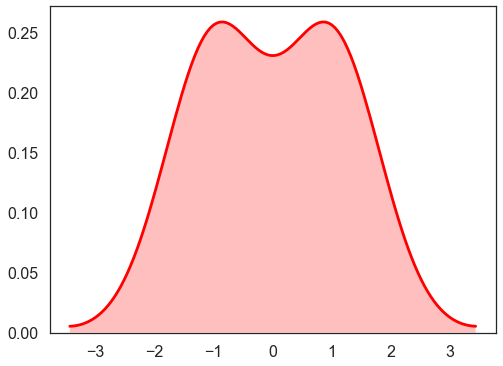

In [55]:
 ax = sns.kdeplot(clown[1], shade=True, color="r")

In [56]:
xclown,yclown= rand_clown(100, 100, 0.1,0.1)
xcheck,ycheck= rand_checkers(100, 100,15)

xbigauss, ybigauss= rand_bi_gauss(n1=100, n2=100, mu1=[1, 1], mu2=[-1, -1], sigmas1=[0.1, 0.1],
                  sigmas2=[0.1, 0.1])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a216ba588>,
      dtype=object)

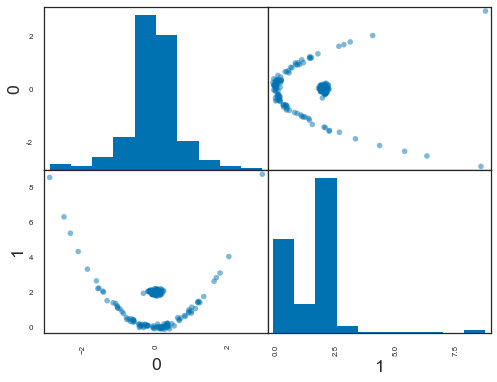

In [57]:
scatter_matrix(pd.DataFrame(xclown))

([array([ 1.,  3., 13., 31., 37., 46., 31., 23.,  5.,  2.]),
  array([ 2.,  4., 13., 42., 32., 34., 35., 21.,  6.,  3.])],
 array([-44.28546538, -35.7312841 , -27.17710282, -18.62292154,
        -10.06874026,  -1.51455897,   7.03962231,  15.59380359,
         24.14798487,  32.70216615,  41.25634743]),
 <a list of 2 Lists of Patches objects>)

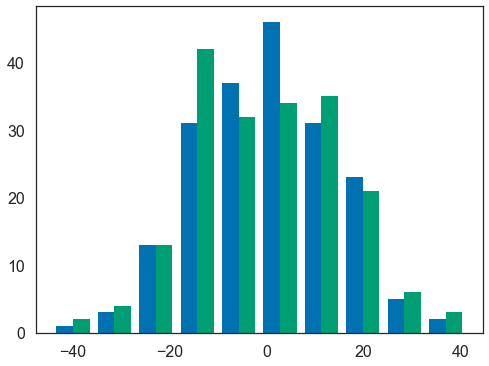

In [58]:
plt.hist(xcheck)

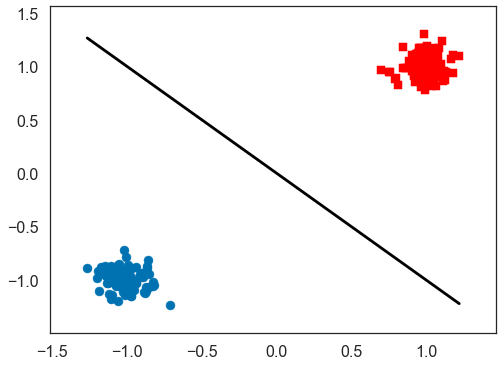

In [59]:
plot_2d(xbigauss,ybigauss,w=[0,1,1])

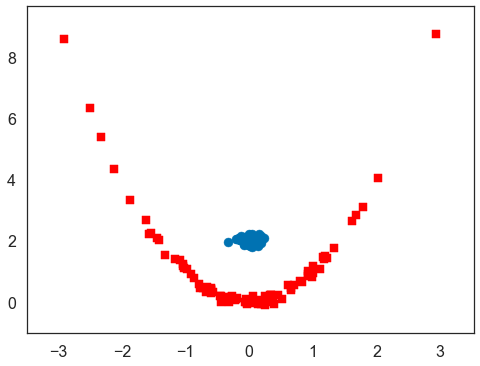

In [60]:
plot_2d(xclown,yclown)

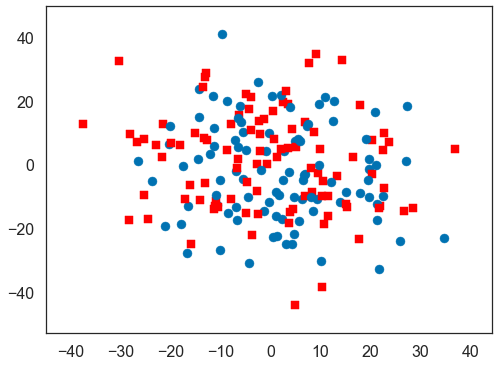

In [61]:
plot_2d(xcheck,ycheck )

In [62]:
xcheck.shape
ycheck.shape

(192,)

In [63]:
ypredNumberbigauss=predict(xbigauss,[0,1,1])

ypredNumberbigauss.shape

(200,)

In [64]:
xbigauss.shape

(200, 2)

In [65]:
ypredbigauss=predict_class(xbigauss,[0,1,1])
xbigauss.shape


(200, 2)

In [66]:
ypredclown=predict(xclown,[0,1,1])

coutclown= ypredbigauss-yclown


In [67]:
#plot_cout(xbigauss,ybigauss,cout)

In [76]:
w,loss=gradient(xclown, yclown, eps=0.01, niter=100, w_ini=np.random.random(3), loss_fun=mse_loss, gr_loss_fun=gr_mse_loss, stochastic=True)

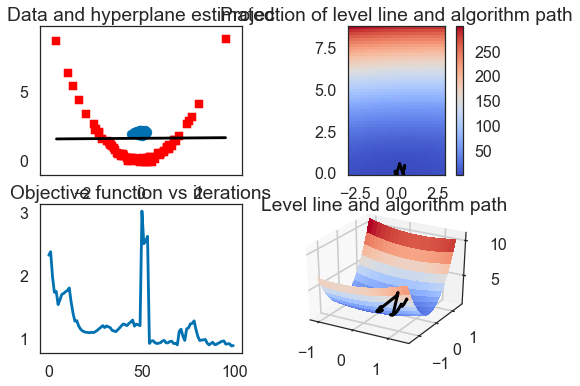

In [77]:
plot_gradient(xclown, yclown, w, loss, mse_loss)